### Uma introdução passo a passo à análise de Cohort em Python

Carregue as bibliotecas necessárias e defina algumas configurações para plotagens.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import numpy as np
from operator import attrgetter
import matplotlib.colors as mcolors

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)

Abre o arquivo com os dados.

In [4]:
df = pd.read_excel('Online Retail.xlsx',
                   dtype={'CustomerID': str,
                          'InvoiceID': str},
                   parse_dates=['InvoiceDate'], 
                   infer_datetime_format=True)

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null object
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df[pd.isnull(df['CustomerID'])].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [7]:
df.dropna(subset=['CustomerID'], inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null datetime64[ns]
UnitPrice      406829 non-null float64
CustomerID     406829 non-null object
Country        406829 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0


compra com valores negativos

In [14]:
np.sum(df.Quantity < 0)

8905

In [15]:
df = df[df['Quantity'] > 0]

In [21]:
n_orders = df.groupby(['CustomerID'])['InvoiceNo'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / df['CustomerID'].nunique()
print(f'{100 * mult_orders_perc:.2f}% realizaram pedido mais de uma vez.')

65.57% realizaram pedido mais de uma vez.


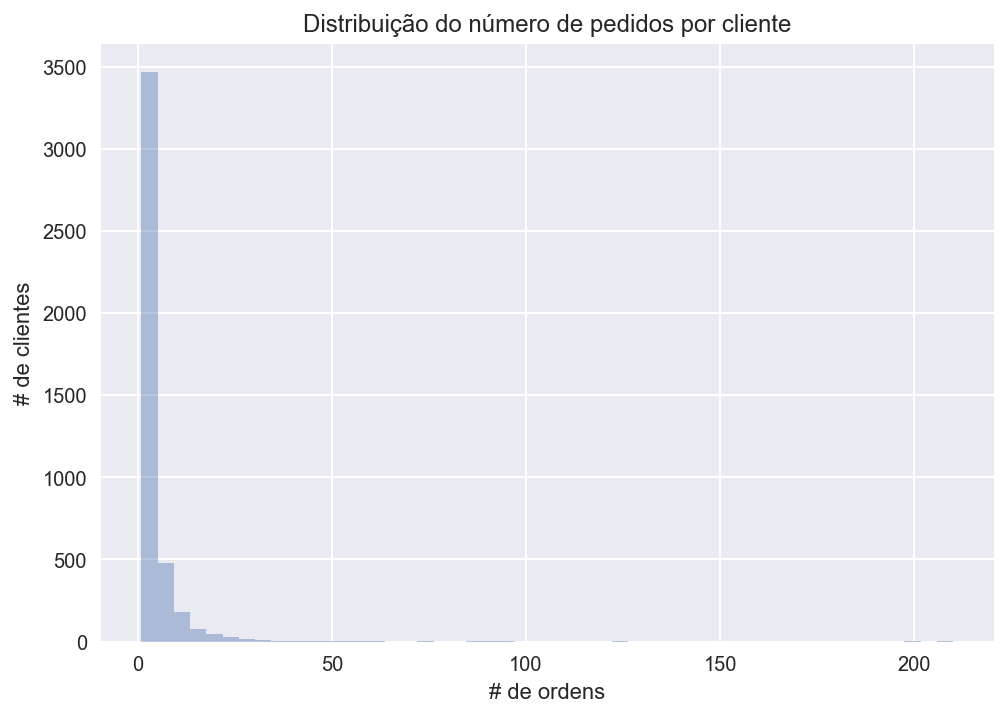

In [22]:
ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribuição do número de pedidos por cliente',
       xlabel='# de ordens', 
       ylabel='# de clientes');

In [23]:
# keep only the relevant data
df = df[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

In [25]:
# create two variables: month of order and cohort
df['order_month'] = df['InvoiceDate'].dt.to_period('M')
df['cohort'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

In [33]:
# add an indicator for periods (months since first purchase)
df_cohort = df.groupby(['cohort', 'order_month']).agg(n_customers=('CustomerID', 'nunique')).reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [40]:
# pivot the data into a form of the matrix
cohort_pivot = df_cohort.pivot_table(index = 'cohort',columns = 'period_number', values = 'n_customers')

In [41]:
# divide by the cohort size (month 0) to obtain retention as %
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

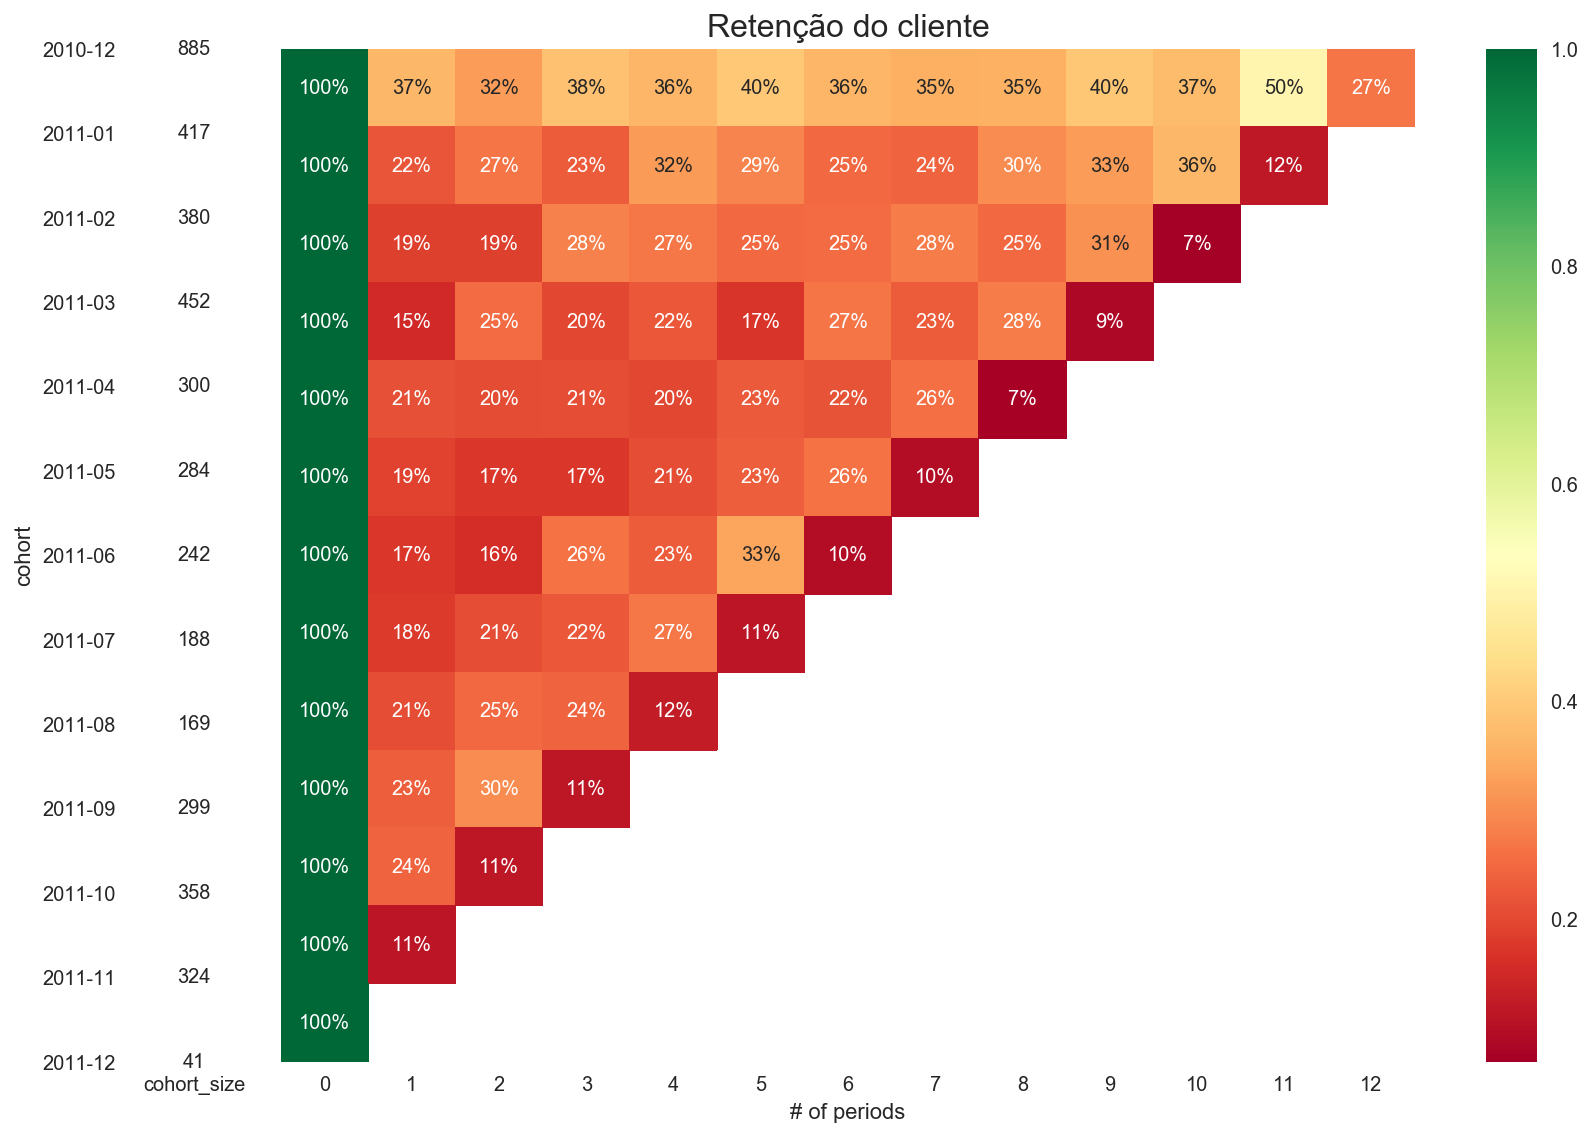

In [47]:
# plot the retention matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Retenção do cliente', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])
    fig.tight_layout()